In [529]:
import altair as alt
from pathlib import Path
import json
import pandas as pd
import numpy as np
import altair_viewer

alt.renderers.enable('altair_viewer', inline=True)

RendererRegistry.enable('altair_viewer')

# Process Data

In [530]:
results = {
    'no-static': ('../results/17_09_51-08_2020/data.csv', '../results/17_09_51-08_2020/sim.csv'),
    'static': ('../results/14_15_10-08_2020/data.csv', '../results/14_15_10-08_2020/sim2.csv'),
    'unrolled': ('../results/14_17_26-08_2020/data.csv', '../results/14_17_26-08_2020/sim.csv')
}
data_lib = {}

for k, v in results.items():
    futil_hls_data = pd.read_csv(v[0])
    futil_latency = pd.read_csv(v[1])
    futil_hls_data = futil_hls_data[futil_hls_data['type'] != 'hls_total']
    for _, row in futil_latency.iterrows():
        bench_filt = futil_hls_data['benchmark'] == row[0]
        type_filt = futil_hls_data['type'] == 'futil'
        futil_hls_data.loc[(bench_filt) & (type_filt), 'latency'] = row[1]
    futil_hls_data = futil_hls_data.sort_values(by='benchmark').reset_index(drop=True)
    futil_hls_data['benchmark'] = futil_hls_data['benchmark'].apply(lambda x: x.split('-')[-1])
    data_lib[k] = futil_hls_data


# Timed Futil vs VHLS Graph

In [531]:
# Generate merged and normalized data for types of benchmarks
import math
merged = {}
KEYS = ['lut', 'latency']

for key in data_lib.keys():
    df = data_lib[key]
    hls = df[df['type'] == 'hls'][['benchmark'] + KEYS]
    futil = df[df['type'] == 'futil'][['benchmark'] + KEYS]
    # Merge the HLS and FuTIL data
    combined = hls.merge(futil, on='benchmark', suffixes = ['-hls', '-futil'])
    # Calculate normalized keys for KEYS
    for norm_key in KEYS:
        combined[f'{norm_key}-norm'] = np.log(combined[f'{norm_key}-futil'] / combined[f'{norm_key}-hls'])
    merged[key] = combined

In [532]:
df1 = merged['static']
df2 = merged['no-static']
df3 = merged['unrolled']
df1['type'] = 'Latency Sensitive'
df2['type'] = 'Latency Insensitive'
df3['type'] = 'Unrolled (Latency Sensitive)'
comp_data = df1.merge(df2, how='outer').merge(df3, how='outer')

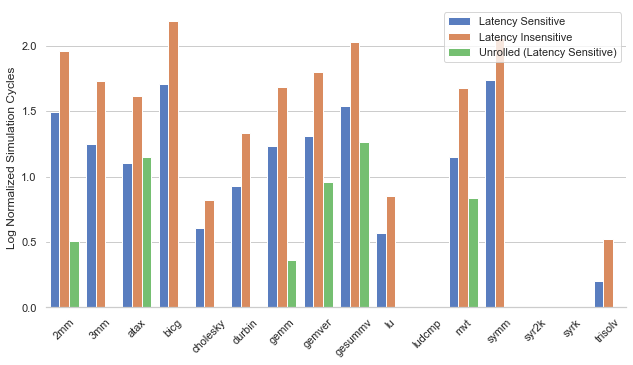

In [533]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

g = sns.catplot(
    x="benchmark", 
    y="latency-norm", 
    hue="type", 
    data=comp_data,
    kind="bar", 
    palette="muted",
    legend=False,
)
g.despine(left=True)
g.set_ylabels("Log Normalized Simulation Cycles")
g.set_xlabels("")
g.set_xticklabels(rotation=45)
g.axes[0,0].legend(loc='upper right').set_title('')
g.fig.set_size_inches(10,5)
g.savefig('log-norm-lat.pdf')

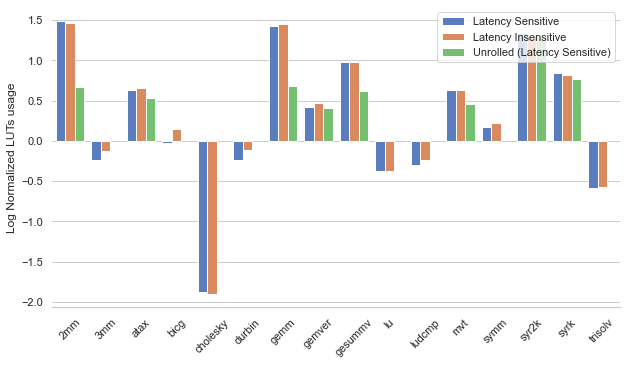

In [534]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")


g = sns.catplot(
    x="benchmark", 
    y="lut-norm", 
    hue="type", 
    data=comp_data,
    kind="bar", 
    palette="muted",
    legend=False,
)
g.despine(left=True)
g.set_ylabels("Log Normalized LUTs usage")
g.set_xlabels("")
g.set_xticklabels(rotation=45)
g.axes[0,0].legend(loc='upper right').set_title('')
g.fig.set_size_inches(10,5)
g.savefig('log-norm-lut.pdf')

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")


g = sns.catplot(
    x="benchmark", 
    y="lut-norm", 
    hue="type", 
    data=comp_data,
    kind="bar", 
    palette="muted",
    legend=False,
)
g.despine(left=True)
g.set_ylabels("Log Normalized LUTs usage")
g.set_xlabels("")
g.set_xticklabels(rotation=45)
g.axes[0,0].legend(loc='upper right').set_title('')
g.fig.set_size_inches(10,5)
g.savefig('log-norm-lut.pdf')

In [538]:


bars = alt.Chart().mark_bar().encode(
    x=alt.X('type', axis=alt.Axis(labels=False, title=None, ticks=False)),
    y=alt.Y('value',
            scale=alt.Scale(type='log'),
            axis=alt.Axis(title="VHLS / Calyx")),
    tooltip=['value', 'latency_mean', 'lut_mean'],
    color=alt.condition('datum.meet_timing == 0', alt.ColorValue('red'), 'type'),
)

vline = alt.Chart().mark_rule(color='black', size=0).encode(y='equal')
# meanLutLine = alt.Chart().mark_rule(color='blue').encode(y='lut_mean')
# meanLatLine = alt.Chart().mark_rule(color='green').encode(y='latency_mean')
height=300
alt.layer(bars, vline, data=data).facet(
    column=alt.Column('benchmark', header=alt.Header(labelOrient='bottom')),
    spacing=1,
).configure_title(
    orient='bottom'
).configure_view(
    continuousHeight=height
).configure_bar(
    y2=height/2
)

alt.FacetChart(...)

# Futil
Static vs No-static

In [ ]:
static = data_lib['static']
no_static = data_lib['no-static']
# df = pd.concat([static, no_static], keys=['static', 'no-static']).reset_index().drop(['level_1'], axis='columns').rename({'level_0': 'timing'}, axis='columns')
df = static[static['type'] == 'futil']
base = df.drop(columns=['source', 'meet_timing', 'dsp', 'type']).sort_values(by='benchmark').reset_index(drop=True)
other = no_static[no_static['type'] == 'futil'].sort_values(by='benchmark').reset_index(drop=True)
base['lut'] /= other['lut']
base['latency'] /= other['latency']
# base['dsp'] /= other['dsp']
data = base.melt(['benchmark'])
height=300
bars = alt.Chart().mark_bar().encode(
    x=alt.X('variable', axis=alt.Axis(labels=False, title=None, ticks=False)),
    y=alt.Y('value',
            scale=alt.Scale(type='log', base=2, domain=(2 ** -0.5, 2 ** 0.5)),
            axis=alt.Axis(title="Latency Sensitive / Latency Insensitive")),
    color=alt.Color('variable', scale=alt.Scale(scheme='tableau10'))
)

alt.layer(bars, data=data).facet(
    column=alt.Column(
        'benchmark',
        header=alt.Header(labelOrient='bottom', labelAngle=0, labelAnchor='middle', labelPadding=20),
    ),
    spacing=1
).configure_view(
    continuousHeight=height,
    strokeWidth=1,
    fill='white',
).configure_bar(
    y2=height/2
)


In [542]:
systolic_data = pd.read_csv('../systolic-experiments/scan/data.csv')
systolic_lat = pd.read_csv('../systolic-experiments/scan/systolic.csv')
hls = pd.read_csv('../results/17_21_55-08_2020/data.csv')
hls = hls[hls['type'] == 'hls'].sort_values(by='benchmark').reset_index(drop=True)
systolic_data = systolic_data[systolic_data['type'] == 'futil'].sort_values(by='benchmark').drop(columns=['meet_timing', 'source', 'type']).reset_index(drop=True)
# systolic_data = systolic_data.drop([0, 4, 6]).reset_index(drop=True)
systolic_data['latency'] = systolic_lat['latency']
systolic_data['latency_hls'] = hls['latency']
# systolic_data['hls_dsp'] = hls['dsp']
# systolic_data['hls_lut'] = hls['lut']
systolic_data['lut / 10'] = systolic_data['lut'] / 10
systolic_data['benchmark'] = systolic_data['benchmark'].apply(lambda x: "{} x {}".format(x.split('_')[1], x.split('_')[1]))
# systolic_data['lat_expect'] = [26 * (x + (np.sqrt(x))) for x in range(1,9)]
d = systolic_data.melt(['benchmark'])
alt.Chart(d).mark_bar().encode(
    x=alt.X('variable', axis=alt.Axis(labels=False, ticks=False,title=None)),
    y='value',
    color='variable',
    column=alt.Column(
        'benchmark', 
        header=alt.Header(labelOrient='bottom', labelAngle=0, labelAnchor='middle', labelPadding=20),
        spacing=1
    ),
    tooltip=['value']
).transform_filter(
    'datum.variable != "lut" & datum.variable != "dsp"'
).configure_view(
    continuousHeight=200
)

alt.Chart(...)

In [546]:
systolic_data = pd.read_csv('../systolic-experiments/scan/data.csv')
systolic_data

,benchmark,type,lut,dsp,latency,meet_timing,source
0,systolic_4,hls,NaN,NaN,NaN,1,systolic-experiments/scan
1,systolic_4,hls_total,NaN,NaN,NaN,1,systolic-experiments/scan
2,systolic_4,futil,2219.0,48.0,0.0,1,systolic-experiments/scan
3,systolic_6,hls,NaN,NaN,NaN,1,systolic-experiments/scan
4,systolic_6,hls_total,NaN,NaN,NaN,1,systolic-experiments/scan
5,systolic_6,futil,7851.0,108.0,0.0,1,systolic-experiments/scan
6,systolic_8,hls,NaN,NaN,NaN,1,systolic-experiments/scan
7,systolic_8,hls_total,NaN,NaN,NaN,1,systolic-experiments/scan
8,systolic_8,futil,14827.0,192.0,0.0,1,systolic-experiments/scan
9,systolic_3,hls,NaN,NaN,NaN,1,systolic-experiments/scan


In [544]:
data_lib['static']

,benchmark,type,lut,dsp,latency,meet_timing,source
0,2mm,hls,939,12,3718.0,1,results/14_15_10-08_2020
1,2mm,futil,4183,12,16486.0,1,results/14_15_10-08_2020
2,3mm,hls,742,9,5043.0,1,results/14_15_10-08_2020
3,3mm,futil,583,9,17513.0,1,results/14_15_10-08_2020
4,atax,futil,1150,6,2161.0,1,results/14_15_10-08_2020
5,atax,hls,610,6,715.0,1,results/14_15_10-08_2020
6,bicg,futil,318,6,1203.0,1,results/14_15_10-08_2020
7,bicg,hls,327,6,218.0,1,results/14_15_10-08_2020
8,cholesky,futil,614,6,2542.0,1,results/14_15_10-08_2020
9,cholesky,hls,4040,6,1385.0,1,results/14_15_10-08_2020
